<h5>This is done in <span style="color:blue">Google colab</span>. If you are doing this in local machine then don't forget to install necessary modules like tenforflow hub, pandas, numpy, tensorflow-text,etc</h5>

In [ ]:
!pip install tensorflow-text

In [3]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df=pd.read_csv("./spam.csv")

In [5]:
df.head(3)['Message'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [6]:
df.groupby('Category').count()

,Message
Category,
ham,4825
spam,747


In [7]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham=df_ham.sample(747)

In [10]:
df_balanced=pd.concat([df_ham, df_spam])

In [11]:
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x:1 if x=="spam" else 0)

In [14]:
df_balanced.sample(5)

,Category,Message,spam
3719,ham,Cool. Do you like swimming? I have a pool and ...,0
2920,ham,Is xy in ur car when u picking me up?,0
1970,spam,You have won a guaranteed £200 award or even £...,1
4896,spam,Want the latest Video handset? 750 anytime any...,1
1781,spam,BIG BROTHER ALERT! The computer has selected u...,1


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train,x_test,y_train,y_test=train_test_split(df_balanced["Message"],df_balanced["spam"],stratify=df_balanced["spam"])

In [17]:
x_train.head(4)

1308    Get 3 Lions England tone, reply lionm 4 mono o...
165     BangBabes Ur order is on the way. U SHOULD rec...
5010    My mobile number.pls sms ur mail id.convey reg...
5116    Thanks. Fills me with complete calm and reassu...
Name: Message, dtype: object

In [18]:
y_train.head(4)

1308    1
165     1
5010    0
5116    0
Name: spam, dtype: int64

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [20]:
def get_sentence_embedding(sentences):
  preprocessed_text=bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)["pooled_output"]

get_sentence_embedding(["500$ discount. hurry up","Dilip you have a volleyball game tomorrow"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.77610546, -0.551759  , -0.75852644, ..., -0.49820265,
        -0.7498885 ,  0.82108516]], dtype=float32)>

In [21]:
e=get_sentence_embedding(["Dilip pokhrel is amazing guy","Elon musk","Jeff bezos","grapes","apple","mango"])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
cosine_similarity([e[0]],[e[3]])

array([[0.79280335]], dtype=float32)

In [24]:
import tensorflow as tf

In [25]:
# Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

# Neural network layers
l1=tf.keras.layers.Dropout(0.1,name="dropout")(outputs['pooled_output'])
l2=tf.keras.layers.Dense(1,activation='sigmoid',name="output")(l1)

# construct the final layers
model=tf.keras.Model(inputs=[text_input],outputs=[l2])

In [26]:
Metrics=[
         tf.keras.metrics.BinaryAccuracy(name="accuracy"),
         tf.keras.metrics.Precision(name="precision"),
         tf.keras.metrics.Recall(name="recall")
]

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=Metrics)

model.fit(x_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 27s 328ms/step - loss: 0.6235 - accuracy: 0.6795 - precision: 0.6922 - recall: 0.6464
Epoch 2/10
35/35 [==============================] - 11s 306ms/step - loss: 0.5001 - accuracy: 0.8241 - precision: 0.8168 - recall: 0.8357
Epoch 3/10
35/35 [==============================] - 11s 307ms/step - loss: 0.4234 - accuracy: 0.8643 - precision: 0.8517 - recall: 0.8821
Epoch 4/10
35/35 [==============================] - 11s 308ms/step - loss: 0.3708 - accuracy: 0.8884 - precision: 0.8822 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 11s 317ms/step - loss: 0.3438 - accuracy: 0.8893 - precision: 0.8838 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 11s 314ms/step - loss: 0.3169 - accuracy: 0.9027 - precision: 0.8881 - recall: 0.9214
Epoch 7/10
35/35 [==============================] - 11s 321ms/step - loss: 0.3009 - accuracy: 0.9062 - precision: 0.8998 - recall: 0.9143
Epoch 8/10
35/35 [================

In [27]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 7s 369ms/step - loss: 0.3457 - accuracy: 0.8824 - precision: 0.8705 - recall: 0.8984


[0.3457362651824951,
 0.8823529481887817,
 0.8704662919044495,
 0.8983957171440125]

In [58]:
model.predict(["congratulations!!! you have won a free travel ticket worth 1000000000$. to get your prizes head over this link"])

1/1 [==============================] - 0s 61ms/step


array([[0.7546153]], dtype=float32)

In [38]:
y_predicted=model.predict(x_test)

12/12 [==============================] - 5s 348ms/step


In [40]:
y_predicted[1:5]

array([[0.03584802],
       [0.8223563 ],
       [0.23844327],
       [0.9789042 ]], dtype=float32)

In [41]:
y_test[1:5]

1078    0
3442    1
777     0
1714    1
Name: spam, dtype: int64

In [43]:
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted[:5]

array([[0],
       [0],
       [1],
       [0],
       [1]])

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
cf_matrix = confusion_matrix(y_test, y_predicted)
print(cf_matrix)

[[162  25]
 [ 19 168]]


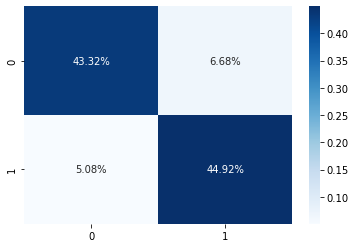

In [57]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%',cmap="Blues")